In [1]:
%run imports.ipynb

In [2]:
snuh_calls = pd.read_excel('source_data/variant_calls.xlsx', sheet_name='SNUH')
snuh_calls.rename({'Name': 'name'}, axis=1).to_csv('source_data/snuh_variant_calls.csv', index=False)

snuh_calls = pd.read_csv('source_data/snuh_variant_calls.csv')
sample2status = {r.name:r.status for r in snuh_calls.to_records()}

In [11]:
pd.DataFrame(snuh_calls.name.str[4:])

,name
0,4794
1,5053
2,5070
3,5160
4,5174
5,5196
6,5323
7,5347
8,5553
9,5576


In [9]:
'\n'.join(snuh_calls.name.str[4:].values)

'4794\n5053\n5070\n5160\n5174\n5196\n5323\n5347\n5553\n5576\n5696\n5763\n6002\n6076\n6407\n4939\n5253\n5996\n5997\n6446'

## Metheor result

In [8]:
def read_metheor_pairs_file(f):
    tmp = pd.read_csv(f, sep='\t')
    
    tmp['distance'] = tmp.cpg2 - tmp.cpg1
    tmp = tmp.groupby('distance').agg({'n_concordant': 'sum', 'n_discordant': 'sum'}).reset_index()
    
    return tmp

In [17]:
metheor_results = glob.glob('/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result/SNUH-RRBS/*.pairs.tsv')
metheor_results = [f for f in metheor_results if os.path.basename(f).split('.')[0] in snuh_calls.name.str[4:].values]
len(metheor_results)

20

In [18]:
pairs_result = []

for f in tqdm(metheor_results):
    run = os.path.basename(f).split('.')[0]
    
    df = read_metheor_pairs_file(f)
    df['name'] = 'SNUH' + run
    
    pairs_result.append(df)
    
pairs_result = pd.concat(pairs_result)

100%|██████████| 20/20 [02:58<00:00,  8.92s/it]


In [23]:
pairs_result['lpmd'] = pairs_result.n_discordant / (pairs_result.n_concordant + pairs_result.n_discordant)

In [32]:
pairs_result['name'] = pairs_result['run']

In [33]:
pairs_result

,distance,n_concordant,n_discordant,run,lpmd,name
0,2,4806341,209705,SNUH5553,0.041807,SNUH5553
1,3,3931142,222005,SNUH5553,0.053455,SNUH5553
2,4,3866019,242609,SNUH5553,0.059049,SNUH5553
3,5,3392547,195775,SNUH5553,0.054559,SNUH5553
4,6,4163944,235795,SNUH5553,0.053593,SNUH5553
...,...,...,...,...,...,...
23,25,866,158,SNUH4794,0.154297,SNUH4794
24,26,47,11,SNUH4794,0.189655,SNUH4794
25,27,14,3,SNUH4794,0.176471,SNUH4794
26,28,6,1,SNUH4794,0.142857,SNUH4794


In [41]:
pairs_result_ann = pairs_result.merge(snuh_calls, on='name')

In [42]:
pairs_result_ann = pairs_result_ann[pairs_result_ann.distance <= 24]

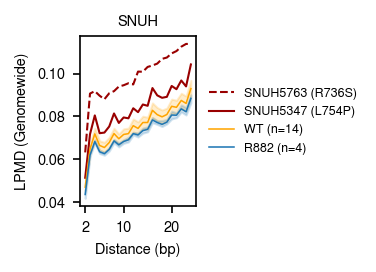

In [49]:
line_kws = {
    'palette': ['orange', 'C0'],
    'lw': 0.75,
    'ci': 68,
}
fig = plt.figure(figsize=(1, 1.5))
ax = fig.add_subplot(111)

ax.set_title('SNUH', pad=5, fontsize=7)

d_5763 = pairs_result_ann[pairs_result_ann.name == 'SNUH5763'].sort_values('distance')
d_5347 = pairs_result_ann[pairs_result_ann.name == 'SNUH5347'].sort_values('distance')

ax.plot(d_5763.distance, d_5763.lpmd, lw=1, ls='--', c='#990000', label='R736S')
ax.plot(d_5347.distance, d_5347.lpmd, lw=1, ls='-', c='#990000', label='L754P')

sns.lineplot(data=pairs_result_ann[pairs_result_ann.status != 'INS'], x='distance', y='lpmd', hue='status', ax=ax, **line_kws)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['SNUH5763 (R736S)', 'SNUH5347 (L754P)', 'WT (n=14)', 'R882 (n=4)'], frameon=False, fontsize=6, bbox_to_anchor=(1.01, 0.5), loc='center left')
ax.set_xticks([2, 10, 20])
ax.set_xlabel('Distance (bp)')
ax.set_ylabel('LPMD (Genomewide)')

# for d in ['top', 'right']:
#     ax.spines[d].set_visible(False)
    
save_figures('source_data_figures/snuh_lpmd/snuh_lpmd')